## Airfoil Self Noise
NASA Dataset obtained form a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel. Different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.

Recommend a model for this data.


In [3]:
# importing the dataset
import pandas as pd
import pandas_profiling as pp
import numpy as np

af_data = pd.read_csv(r'C:\Users\lilye\Downloads\AirfoilSelfNoise.csv')

In [4]:
# exploratory data analysis
from pandas_profiling import ProfileReport
prof_df = ProfileReport(af_data)
prof_df

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# split the data into training and test dataset
# target is SSPL
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(af_data.drop('SSPL', axis=1), af_data['SSPL'], 
                                                     train_size=0.75)


In [11]:
# Standardize the training features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(x_train)
scaled_features_test = scaler.fit_transform(x_test)


In [33]:
# Linear Regression Class to predict SSPL with standardized features
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

scaled_lr = LinearRegression()
scaled_lr.fit(scaled_features_train, y_train)
#print(scaled_lr.score(scaled_features_train, y_train))

scaled_lr.fit(scaled_features_test, y_test)
#print(scaled_lr.score(scaled_features_test, y_test))

# making prediction for SSPL with the linear model and x test data
predict_testdat = scaled_lr.predict(scaled_features_test)
# prediction for train set
predict_traindat = scaled_lr.predict(scaled_features_train)

# quantify the R2 and MSE using the training and test sets
r2_score_train = r2_score(y_train,scaled_lr.predict(scaled_features_train))
r2_score_test = r2_score(y_test,predict_testdat)

print('Train Dataset R2:', r2_score_train)
print('Test Dataset R2:', r2_score_test)



Train Dataset R2: 0.5036135582095694
Test Dataset R2: 0.5406949907678127


In [32]:
from sklearn.metrics import mean_squared_error as mse

mse_test = mse(y_test, predict_testdat)
mse_train = mse(y_train, scaled_lr.predict(scaled_features_train))

print('Test Dataset Mean Squared Error:', mse_test)
print('Train Dataset Mean Squared Error:', mse_train)


Test Dataset Mean Squared Error: 22.358462770791686
Train Dataset Mean Squared Error: 23.42269232239906


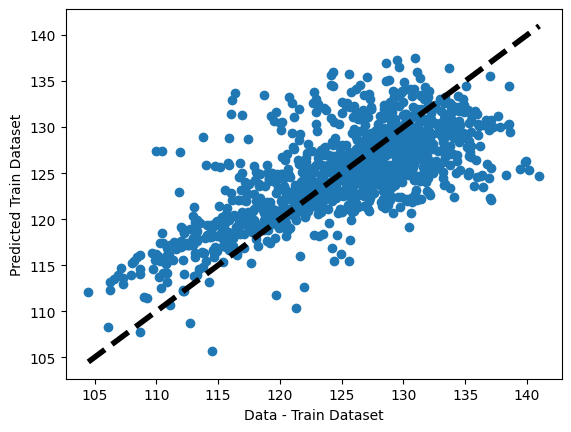

In [37]:
# plotting the training predicted SSPL vs data SSPL
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_train, predict_traindat)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Data - Train Dataset')
ax.set_ylabel('Predicted Train Dataset')
plt.show()

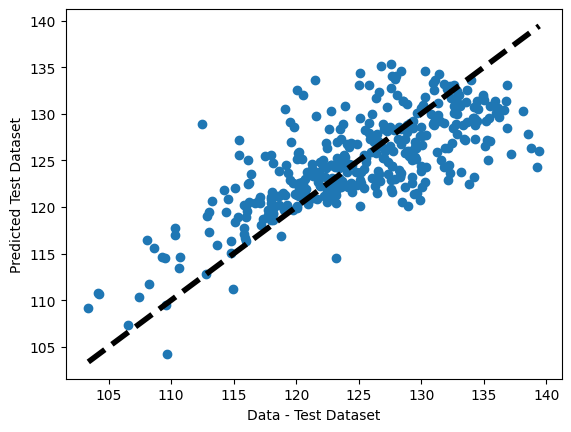

In [40]:
# plotting the test predicted SSPL vs data SSPL
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, predict_testdat)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Data - Test Dataset')
ax.set_ylabel('Predicted Test Dataset')
plt.show()

The model has near 50% and 54% for R2 values, which means that it isn't a perfect fit or correlation. The MSE values are relatively low so that is a good indication that the regression model is somewhat close to the data. 

In [96]:
# Ridge class linear regression 
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

l2_lr = Ridge()
hyperparameters = {'alpha': loguniform(1e-5,100),
                  'fit_intercept': [True,False],
                  'solver': ['svd', 'cholesky', 'lsqr', 'sag'] 
                  }
rs = RandomizedSearchCV(l2_lr, hyperparameters, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

#Ridge Class
l2_lr.fit(scaled_features_train, y_train)
# making prediction for test
rpredict_testdat = l2_lr.predict(scaled_features_test)
# prediction for train set
rpredict_traindat = l2_lr.predict(scaled_features_train)



train_ridge_data = rs.fit(scaled_features_train, y_train)
print('Training Dataset Ridge class Results:')
print(train_ridge_data.best_estimator_)
print(train_ridge_data.best_params_)
print(train_ridge_data.best_score_)

train_ridge_predict = rs.fit(scaled_features_train, rpredict_traindat)
print('Training Predicted Data Ridge class results:')
print(train_ridge_predict.best_estimator_)
print(train_ridge_predict.best_params_)
print(train_ridge_predict.best_score_)

test_ridge_data = rs.fit(scaled_features_test, y_test)
print('Test Dataset Ridge class results:')
print(test_ridge_data.best_estimator_)
print(test_ridge_data.best_params_)
print(test_ridge_data.best_score_)

test_ridge_predict = rs.fit(scaled_features_test, rpredict_testdat)
print('Test Predicted Data Ridge class results:')
print(test_ridge_predict.best_estimator_)
print(test_ridge_predict.best_params_)
print(test_ridge_predict.best_score_)

Training Dataset Ridge class Results:
Ridge(alpha=1.330324510152291, solver='svd')
{'alpha': 1.330324510152291, 'fit_intercept': True, 'solver': 'svd'}
-23.452485779966025
Training Predicted Data Ridge class results:
Ridge(alpha=0.00012363188277052212, solver='lsqr')
{'alpha': 0.00012363188277052212, 'fit_intercept': True, 'solver': 'lsqr'}
-1.4806085225397935e-12
Test Dataset Ridge class results:
Ridge(alpha=1.330324510152291, solver='svd')
{'alpha': 1.330324510152291, 'fit_intercept': True, 'solver': 'svd'}
-23.443433550324723
Test Predicted Data Ridge class results:
Ridge(alpha=0.00012363188277052212, solver='lsqr')
{'alpha': 0.00012363188277052212, 'fit_intercept': True, 'solver': 'lsqr'}
-1.3773230162530691e-11


In [97]:
# R score for ridge fit of dataset
r2_score_train_ridge = r2_score(y_train, rpredict_traindat)
r2_score_test_ridge = r2_score(y_test,rpredict_testdat)
print('Ridge Class: Train Dataset R2:', r2_score_train_ridge)
print('Ridge Class: Test Dataset R2:', r2_score_test_ridge)

# MSE for ridge fit
mse_test_ridge = mse(y_test, rpredict_testdat)
mse_train_ridge = mse(y_train, rpredict_traindat)

print('Test Dataset Mean Squared Error:', mse_test_ridge)
print('Train Dataset Mean Squared Error:', mse_train_ridge)

Ridge Class: Train Dataset R2: 0.5082996420951214
Ridge Class: Test Dataset R2: 0.5362954552501789
Test Dataset Mean Squared Error: 22.572627321803726
Train Dataset Mean Squared Error: 23.20157286423591


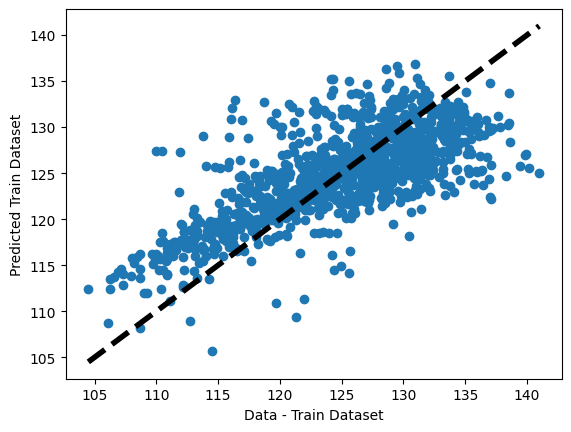

In [87]:
# plotting the training predicted SSPL vs data SSPL
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_train, rpredict_traindat)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Data Ridge - Train Dataset')
ax.set_ylabel('Predicted Ridge Train Dataset')
plt.show()

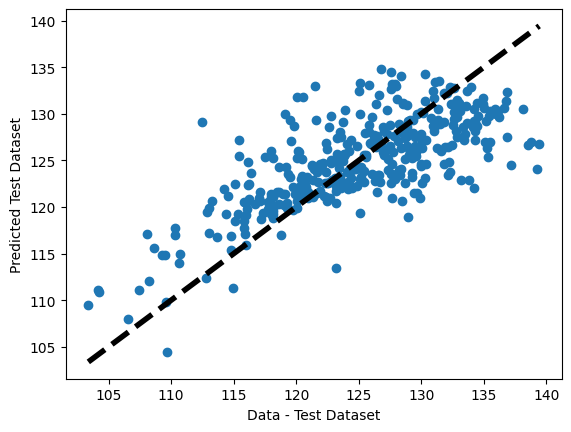

In [88]:
# plotting the test predicted SSPL vs data SSPL
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, rpredict_testdat)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Data Ridge - Test Dataset')
ax.set_ylabel('Predicted Ridge Test Dataset')
plt.show()

The plots are very similar to the first model. The decimal values are slightly different for the R2 and MSE values though. The ridge model produced 1% lower R2 value for the test dataset. 

In [98]:
# KNN regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
hyperparameters = {'n_neighbors': [3,4,5,6]
                  }

gs = GridSearchCV(knn, hyperparameters, scoring='neg_mean_squared_error', n_jobs=-1)
gs.fit(scaled_features_train, y_train)

knn.fit(scaled_features_train, y_train)
# making prediction for test
kpredict_testdat = knn.predict(scaled_features_test)
# prediction for train set
kpredict_traindat = knn.predict(scaled_features_train)






In [99]:
train_knn_data = gs.fit(scaled_features_train, y_train)
print('Training Dataset KNN class Results:')
print(train_knn_data.best_estimator_)
print(train_knn_data.best_params_)
print(train_knn_data.best_score_)

train_knn_predict = gs.fit(scaled_features_train, kpredict_traindat)
print('Training Predicted Data KNN class results:')
print(train_knn_predict.best_estimator_)
print(train_knn_predict.best_params_)
print(train_knn_predict.best_score_)

test_knn_data = gs.fit(scaled_features_test, y_test)
print('Test Dataset KNN class results:')
print(test_knn_data.best_estimator_)
print(test_knn_data.best_params_)
print(test_knn_data.best_score_)

test_knn_predict = gs.fit(scaled_features_test, kpredict_testdat)
print('Test Predicted Data KNN class results:')
print(test_knn_predict.best_estimator_)
print(test_knn_predict.best_params_)
print(test_knn_predict.best_score_)

Training Dataset KNN class Results:
KNeighborsRegressor(n_neighbors=3)
{'n_neighbors': 3}
-10.59183661424888
Training Predicted Data KNN class results:
KNeighborsRegressor(n_neighbors=3)
{'n_neighbors': 3}
-2.150501792596525
Test Dataset KNN class results:
KNeighborsRegressor(n_neighbors=4)
{'n_neighbors': 4}
-17.25070531482676
Test Predicted Data KNN class results:
KNeighborsRegressor(n_neighbors=3)
{'n_neighbors': 3}
-8.054035762909468


In [100]:
# R score for KNN fit of dataset
r2_score_train_knn = r2_score(y_train, kpredict_traindat)
r2_score_test_knn = r2_score(y_test,kpredict_testdat)
print('KNN : Train Dataset R2:', r2_score_train_knn)
print('KNN : Test Dataset R2:', r2_score_test_knn)

# MSE for KNN fit
mse_test_knn = mse(y_test, kpredict_testdat)
mse_train_knn = mse(y_train, kpredict_traindat)

print('Test Dataset Mean Squared Error:', mse_test_knn)
print('Train Dataset Mean Squared Error:', mse_train_knn)

KNN : Train Dataset R2: 0.8692852132941475
KNN : Test Dataset R2: 0.7956856580789963
Test Dataset Mean Squared Error: 9.945797488723397
Train Dataset Mean Squared Error: 6.167961034463178


The K nearest neighbors model fits the dataset much better as the R2 values are closer to 1. Also, the Mean squared error values are lower and closer to zero which indicates a lower squared error value.

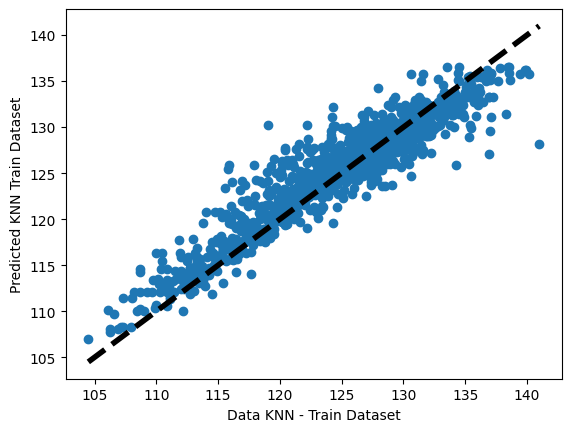

In [102]:
# plotting the training predicted SSPL vs data SSPL
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_train, kpredict_traindat)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Data KNN - Train Dataset')
ax.set_ylabel('Predicted KNN Train Dataset')
plt.show()

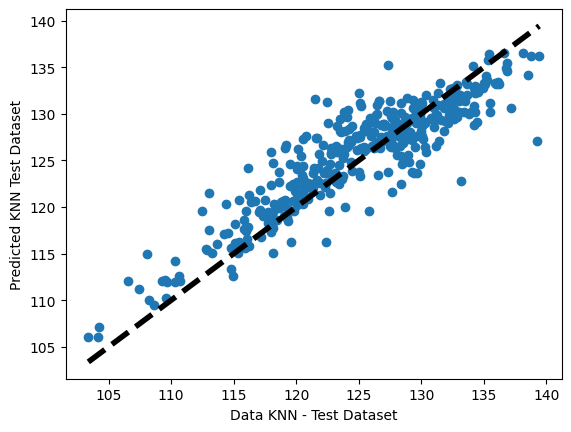

In [103]:
# plotting the test predicted SSPL vs data SSPL
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, kpredict_testdat)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Data KNN - Test Dataset')
ax.set_ylabel('Predicted KNN Test Dataset')
plt.show()

Based on the analysis I would recommend the K Nearest Neighbor model. This model yielded the lowest mean squared error values and had a high R2 value which means it the model fits the data better and is more correlated. I thought the ridge model would have shown more of an improvement from the linear one, but the results were not much different than that model. 